In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
from src.exploratory_functions import *

In [3]:
# Update custom parameters
plt.rcParams.update({
    'font.family': 'serif',  
    'font.size': 8,          
    'axes.labelsize': 14,    
    'axes.titlesize': 16,    
    'lines.linewidth': 1.5,  
    'figure.dpi': 100,
})

In [4]:
# custom variables
base_dir = os.path.abspath(os.path.join(os.getcwd(), '.', '..'))
path_silver = os.path.join(base_dir, 'data', 'silver')
path_gold = os.path.join(base_dir, 'data', 'gold')
file_name = 'dailymaxtemperature.csv'
full_path_silver = os.path.join(path_silver, file_name)
sep = ','
date_column = 'Fecha'
target_column = 'Valor' # How is called in the csv original
renamed_target = 'temperature'
path_image = os.path.join(base_dir, 'documents', 'figures')
print(full_path_silver)
print(path_image)

/Users/gloriacarrascal/master/research_data/dm_project/data/silver/dailymaxtemperature.csv
/Users/gloriacarrascal/master/research_data/dm_project/documents/figures


In [5]:
def main():
    # load data
    data = load_data(full_path_silver, sep, date_column) 
    data =  process_observation_period(data, date_column)
    data = preprocess_data(data, date_column, target_column, renamed_target)   
    # Replace commas with points
    data = data.apply(replace_commas_with_points)
    return data
processed_data = main()
processed_data.head()

,temperature
Fecha,
2000-01-01,34.2
2000-01-02,33.2
2000-01-03,33.8
2000-01-04,33.2
2000-01-05,33.4


In [6]:
processed_data.index.min(), processed_data.index.max()

(Timestamp('2000-01-01 00:00:00'), Timestamp('2024-12-05 00:00:00'))

In [10]:
processed_data[renamed_target].to_csv(f'{path_silver}/{renamed_target}_processed.csv', index=True)

## Exploratory Data analysis
**Univariate analysis: Maximun daily temperature from 2000-01-01 to 2024-12-05**

In [7]:
processed_data[renamed_target].describe().T

count    7176.000000
mean       34.722533
std         1.781985
min        26.400000
25%        33.800000
50%        34.600000
75%        36.000000
max        40.200000
Name: temperature, dtype: float64

### Temporal Serie and Seasonl Decomposition

In [16]:
def serie_and_decomposition(data, target):
    # Generate the monthly temporal series
    temporal_serie(data, target)
    # Find the decomposition of the temporal serie
    decomposition, selected_type = seasonal_decompositions(data, target)
    # Plot the trend
    trend(decomposition, target)
    # Plot the seasonality
    seasonality_decomposition(decomposition, target)
    # Plot the distribution of the serie/first view
    hist_plot(data, target)
    seasonality(data, target)

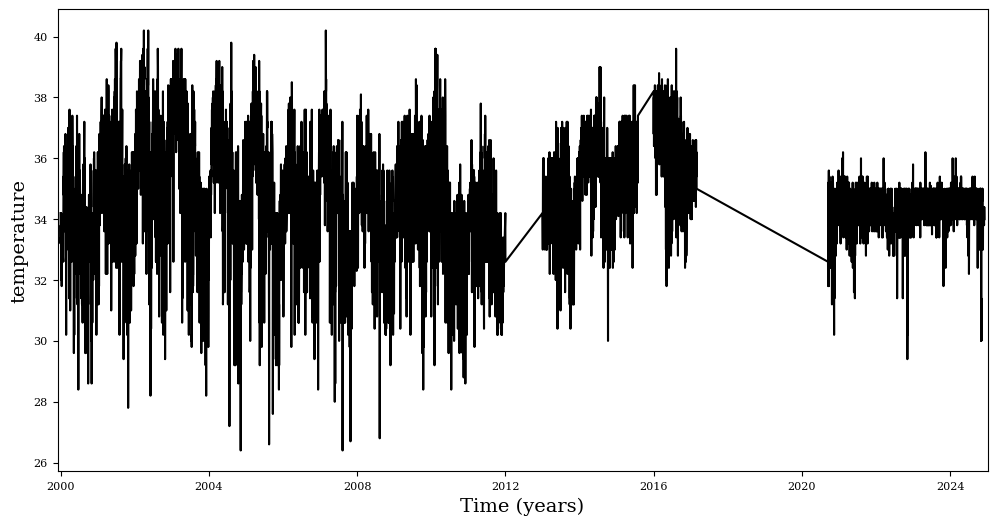

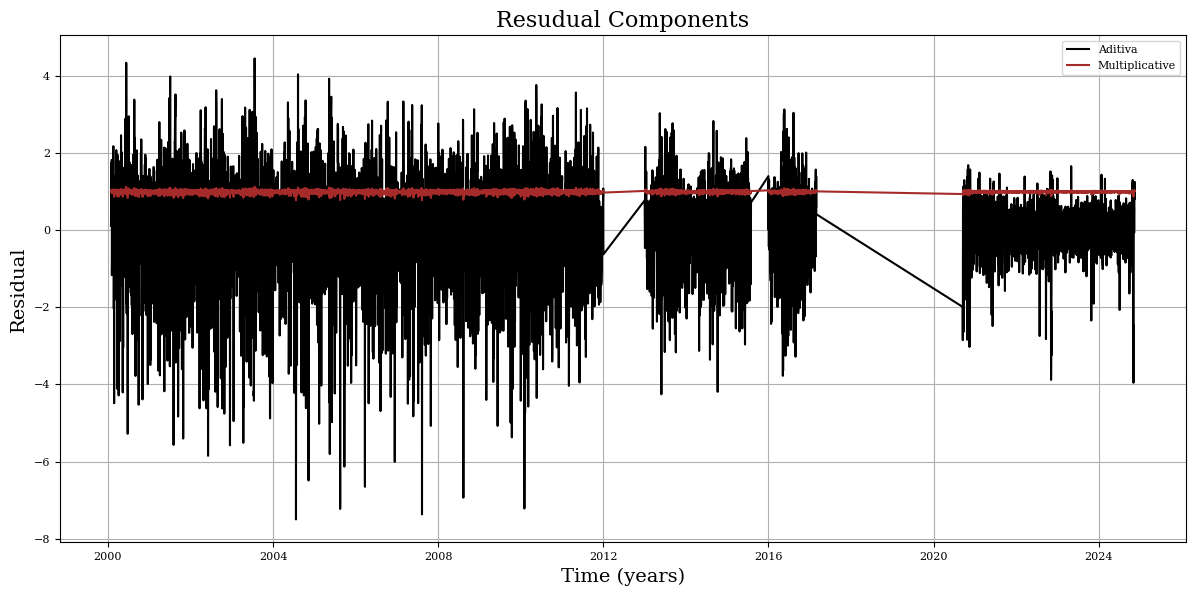

This is the selected decomposition multiplicative


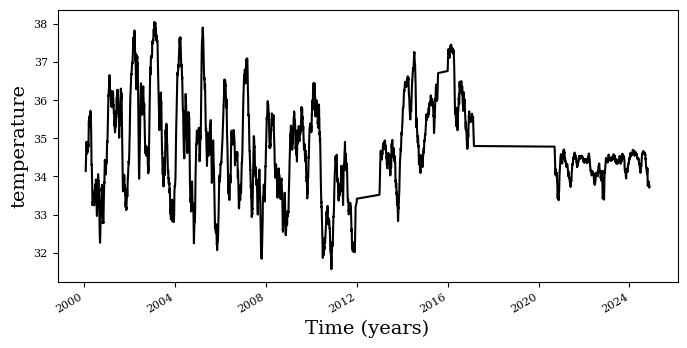

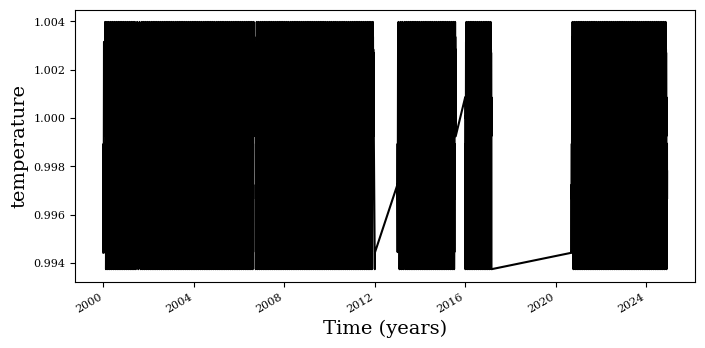

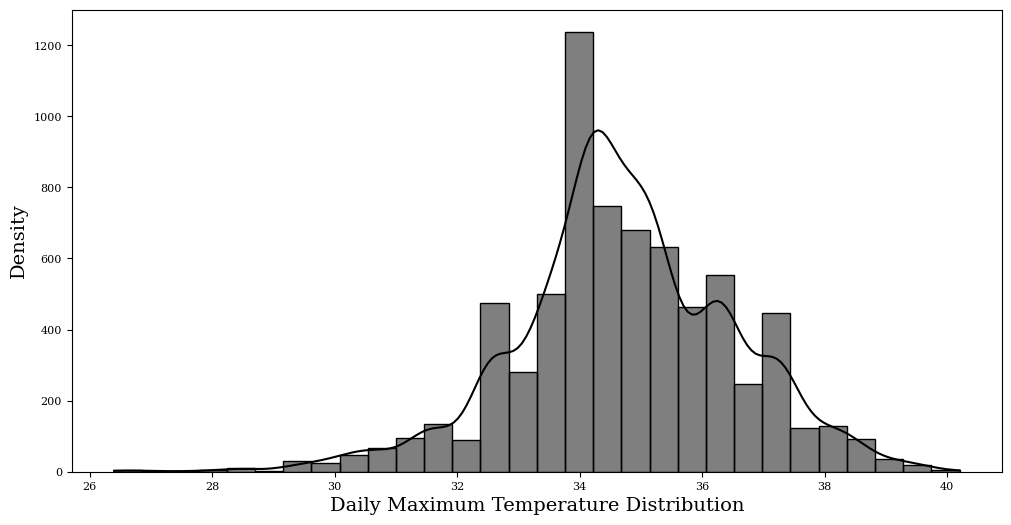

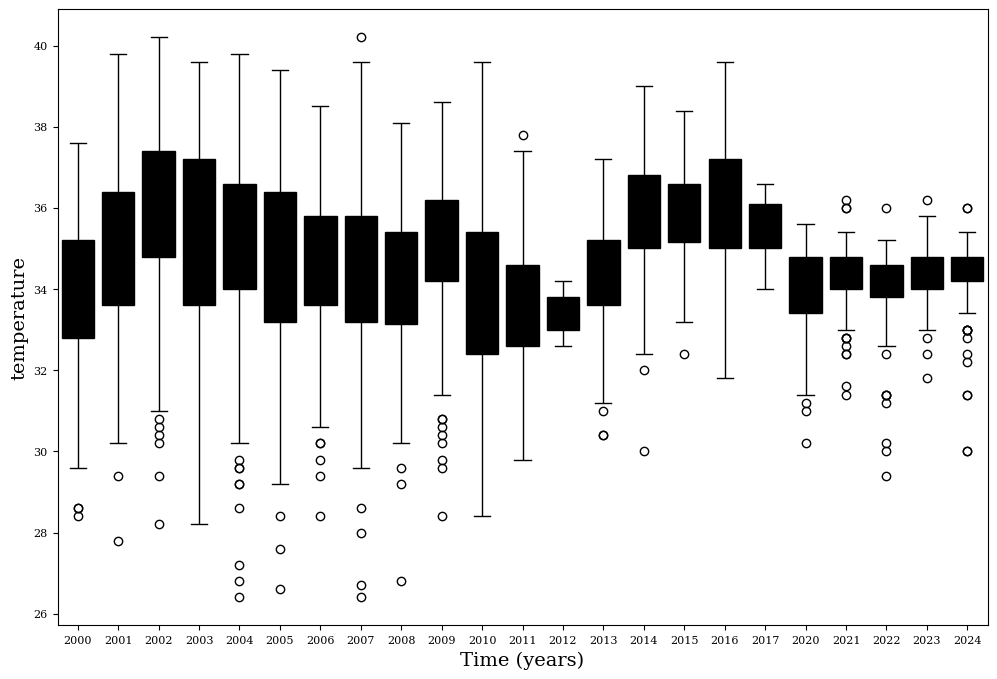

In [17]:
serie_and_decomposition(processed_data, renamed_target)

#### Conclusions Temporal Serie
- There have been some years without data being registered.
- The decomposition applied is multiplicative
- At first view, the series follows a normal distribution
- In terms of outliers, it is evident the presence through the years.

### Transformation

In [8]:
def tranformation_functions():
    # Variance unoformity tests
    test_result = homogeneity_variance_test(processed_data, renamed_target)
    print(test_result)
    # Boxcox transformation
    transformed_data = apply_boxcox(processed_data, renamed_target)
    # missing values
    data_ready = handle_missing_values(transformed_data, renamed_target)
    return data_ready
data_ready = tranformation_functions()
data_ready.head()

---------------------------------------------------------------------------------------------------
Alert: The null hypothesis of homoscedasticity is rejected. There is no constant variation; that is, the outliers
They are very significant
BartlettResult(statistic=np.float64(314.7450017378354), pvalue=np.float64(2.0210770569142556e-70))
---------------------------------------------------------------------------------------------------
If lambda equals 1: No transformation is applied
---------------------------------------------------------------------------------------------------
              count       mean       std   min   25%   50%   75%   max
temperature  7176.0  34.722533  1.781985  26.4  33.8  34.6  36.0  40.2
---------------------------------------------------------------------------------------------------
No null values found in the column. Skipping imputation.


,temperature
Fecha,
2000-01-01,34.2
2000-01-02,33.2
2000-01-03,33.8
2000-01-04,33.2
2000-01-05,33.4


**The rejection of the Null Hypothesis of Homoscedasticity suggests that there may be high variations between the maximum daily temperature values, and this should be explored in detail to identify the outliers.** 

### Exploring the distribution

In [9]:
distributions_list = ['norm', 'expon', 'gamma', 'lognorm', 'chi2', 'beta', 'uniform', 'cauchy', 'weibull_min', 
'weibull_max', 'pareto', 'triang', 't', 'f']     # List of distributions to test

In [10]:
def distribution_and_stationarity_exploration(data, target):
    # finding the best distribution
    p_values, best_distribution = find_best_distribution(data[target], distributions_list)
    print("P-values:", p_values)
    print("Best distribution:", best_distribution)
    # Good-Fitness test
    p_value_goodness_of_fit = goodness_of_fit_test(data[target])
    print("Goodness-of-fit test p-value:", p_value_goodness_of_fit)
    #first stationarity test
    dftest, kpss_result = perform_kpss_and_dfuller_test(data, target)
        # Plot the autocorrelation
    acf_test(data, target)
    # Plot the partial autocorrelation
    pacf_test(data, target)
    # Transform data if is or not stationary, show test again if is transformed
    stationary_data = make_stationary(data, target, 0.05)
    stationary_data.head()

    return stationary_data

/opt/anaconda3/envs/etl_ideam/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:795: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/opt/anaconda3/envs/etl_ideam/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:800: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


P-values: 2.5206713249559793e-20
Best distribution: t
---------------------------------------------------------------------------------------------------
Null Hypotesis (H_o) Distribution:
---------------------------------------------------------------------------------------------------
There is no significant difference between the observed frequencies and the expected frequencies
assuming a uniform distribution
---------------------------------------------------------------------------------------------------
We reject the null hypothesis. This indicates that there is a significant difference between the observed frequencies and the expected 
frequencies assuming a uniform distribution. We can conclude that the data does not fit the uniform distribution well, and there may be a 
systematic deviation from uniformity.
Goodness-of-fit test p-value: 0.0
----------------------------------------------------------------------------------------
Null Hypotesis ADF and KPSS tests:
- ADF test 

/Users/gloriacarrascal/master/research_data/dm_project/src/exploratory_functions.py:285: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(data[target], regression=regression)


----------------------------------------------------------------------------------------
Resuls ADF test
----------------------------------------------------------------------------------------
   ADF: -6.493157658422055
   P-Value: 1.212478868808369e-08
   Num Of Lags: 28
   Num Of Observations Used For ADF Regression and Critical Values Calculation: 7147
   Critical Values: {'1%': np.float64(-3.4312653001585067), '5%': np.float64(-2.861944490443581), '10%': np.float64(-2.5669853061469206)}
----------------------------------------------------------------------------------------
Resuls KPSS test
----------------------------------------------------------------------------------------
KPSS Statistic: 0.2496178945031739
p-value: 0.01
Lags Used: 49
Critical Values:
   10%: 0.119
   5%: 0.146
   2.5%: 0.176
   1%: 0.216


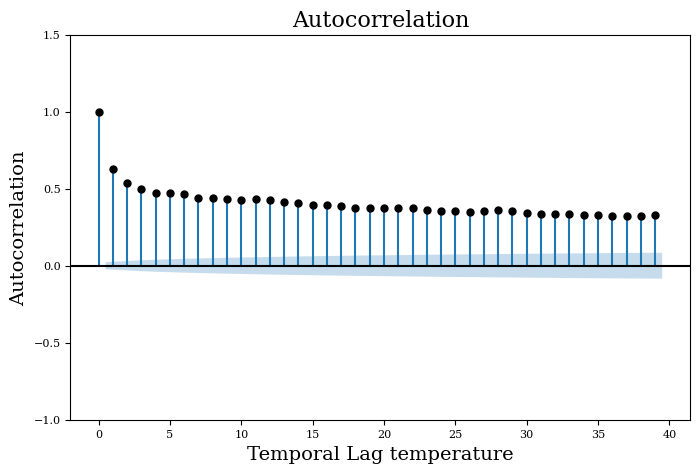

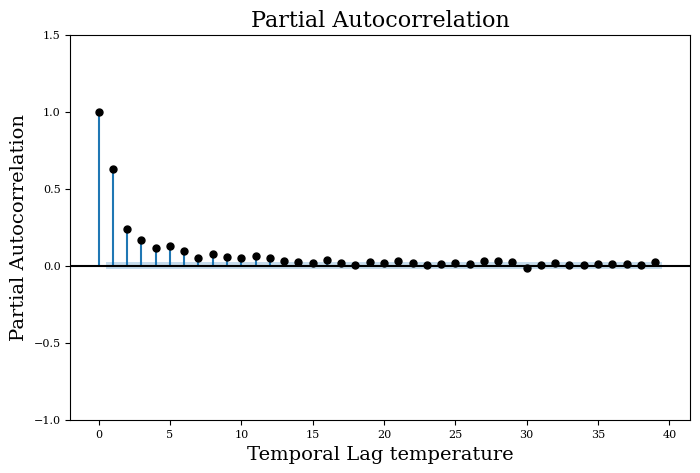

Data is non-stationary. Applying first differencitation...
Note: You should compute dftest, and kpss test again


/Users/gloriacarrascal/master/research_data/dm_project/src/exploratory_functions.py:314: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(data[target], regression='ct')


In [11]:
_data_to_export = distribution_and_stationarity_exploration(data_ready, renamed_target)

### Conclusions from the exploration of distribution 
**Significance value=0.05**

- The serie follows a t-student distribution, which implies high advantajes for modelling such that predictions and confidence intervals may be more realistic, as they incorporate the likelihood of extreme events.
- The ADF test statistic of -6.4932 is significantly more negative than all three critical values at the 1%, 5%, and 10% significance levels.
    - The p-value of 1.2125e-08 is extremely small, which strongly supports rejecting the null hypothesis.
    - Therefore, we reject the null hypothesis and conclude that the series is stationary at all significance levels (1%, 5%, and 10%).
- The KPSS test statistic 0.25 is similar to the values in all the three critical values at the 1%, 5%, and 10% significance levels.
    - At the levels 1% we can not reject the null hypothesis, the values are almost equal.
    - In the others levels, these values are lower than KPSS static which suggest that the serie is not stationary.
- The analysis of autocorrelation and partial autocorrelation indicates that the series is non-stationary and exhibits periodicity, particularly in lags 1 to 10, as observed in the partial autocorrelation.


In [ ]:
# Appying ADF and KPSS test again to confirm if the time serie is stationary at first differentation
dftest, kpss_result = perform_kpss_and_dfuller_test(_data_to_export, renamed_target)

----------------------------------------------------------------------------------------
Null Hypotesis ADF and KPSS tests:
- ADF test Ho: If the p-value is less than the significance level, we reject the null hypothesis
and conclude that the time series is stationary.
- KPSS test Ho: If the p-value is greater than the significance level, we fail to reject the null
hypothesis, indicating that there is not enough evidence to conclude that the time series is stationary.
----------------------------------------------------------------------------------------
Resuls ADF test
----------------------------------------------------------------------------------------
   ADF: -23.901529742142124
   P-Value: 0.0
   Num Of Lags: 27
   Num Of Observations Used For ADF Regression and Critical Values Calculation: 7147
   Critical Values: {'1%': np.float64(-3.4312653001585067), '5%': np.float64(-2.861944490443581), '10%': np.float64(-2.5669853061469206)}
-----------------------------------------------

/Users/gloriacarrascal/master/research_data/dm_project/src/exploratory_functions.py:285: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(data[target], regression=regression)


- In the KPSS test, the values from all the significance levels (1%, 2.5%, 5%, 10%) are greater than the KPSS statistic. The time serie is stationary!
- The ADF test does not provide strong evidence to reject the null hypotesis (The time series is stationary), because the p-values is 0.0, but the ADF statisc is more negative than all the significance levels values.

In [13]:
stationary_data = make_stationary(_data_to_export, renamed_target, 0.05)
stationary_data.head()

The time series is already stationary.


/Users/gloriacarrascal/master/research_data/dm_project/src/exploratory_functions.py:314: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(data[target], regression='ct')


,temperature
Fecha,
2000-01-02,-1.0
2000-01-03,0.6
2000-01-04,-0.6
2000-01-05,0.2
2000-01-06,-0.6


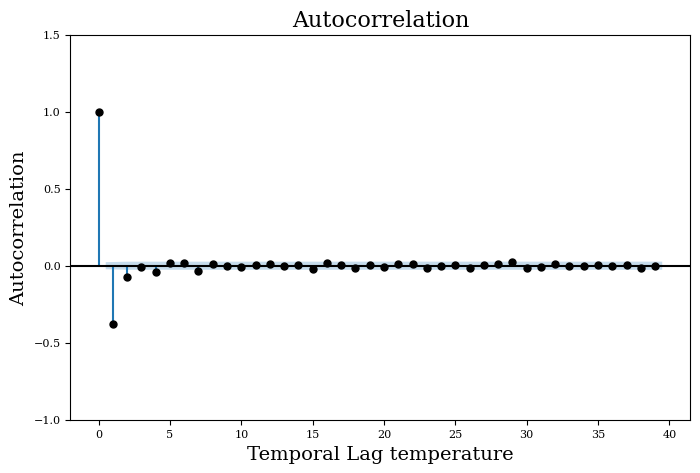

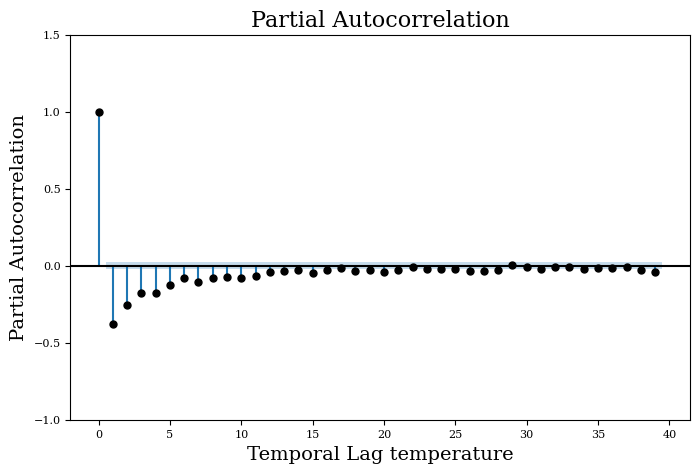

In [14]:
acf_test(stationary_data, renamed_target)
# Plot the partial autocorrelation
pacf_test(stationary_data, renamed_target)

In [15]:
stationary_data[renamed_target].to_csv(f'{path_silver}/{renamed_target}_stationary.csv', index=True)